In [1]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from PIL import Image
from PIL.ImageDraw import Draw
import random
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from char_recognizer.model import *
from char_recognizer.utils import *
from char_recognizer.train import *
from char_recognizer.inference import inference

# Model Training

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

datatset_path = '../datasets/dataset_v6'

batch_size = 900
num_epochs = 60
lr = 1e-3

In [4]:
# Set a random seed for reproducibility
seed = 23
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

dataset = CharDataset(datatset_path, transform=transform, max_crop_error=0.1)

total_size = len(dataset)
train_size = int(0.90 * total_size)
#val_size = int(0.10 * total_size)
#test_size = total_size - train_size - val_size
val_size = total_size - train_size

# Randomly split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataset.transform = transform_noise

# Create the DataLoader for the training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, collate_fn=custom_collate, prefetch_factor=2)

# Create the DataLoader for the validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, collate_fn=custom_collate, prefetch_factor=2)

In [5]:
model = CharRecognizer(dropout_rate=0.3, device=device).to(device)

In [6]:
model, train_loss_history, val_loss_history = train(model, train_loader, val_loader, num_epochs, lr, device, alpha=0.75, gamma=4, checkpoint_dir='char_recognizer/checkpoints')

Training:   2%|▏         | 17/1000 [01:57<1:52:47,  6.88s/it]


KeyboardInterrupt: 

In [ ]:
plot_loss(train_loss_history, val_loss_history)

## Model Loading from Checkpoint

In [5]:
model = CharRecognizer(dropout_rate=0.3, device=device).to(device)
epoch, train_loss_history, val_loss_history = load_checkpoint('char_recognizer/checkpoints/model_epoch_35.pth', model, weights_only=False)

/mnt/d/Documents/GitHub/captcha_solver/captcha_solver/char_recognizer/train.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded from char_recognizer/checkpoints/model_epoch_35.pth, Epoch: 35


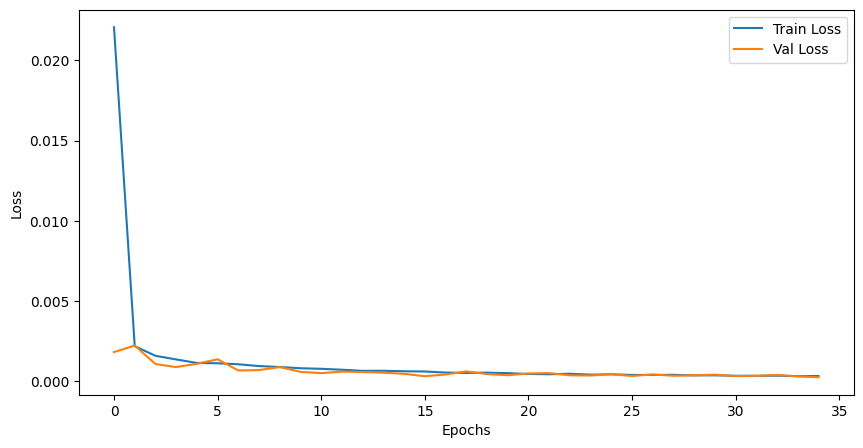

In [6]:
plot_loss(train_loss_history, val_loss_history)

## Model Inference for Testing

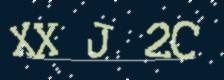

X -> [('H', 0.29471513628959656), ('W', 0.14513982832431793), ('K', 0.11605668067932129), ('M', 0.10722868144512177), ('X', 0.07784873247146606)]
X -> [('H', 0.4040300250053406), ('K', 0.08760715276002884), ('X', 0.05873182415962219), ('W', 0.05665900185704231), ('Y', 0.04406087473034859)]
J -> [('H', 0.30391907691955566), ('T', 0.16554176807403564), ('W', 0.11585529148578644), ('5', 0.1134517639875412), ('U', 0.04300205782055855)]
2 -> [('3', 0.37801969051361084), ('2', 0.23978273570537567), ('8', 0.1407124549150467), ('9', 0.0633891224861145), ('1', 0.04203582927584648)]
C -> [('G', 0.5624882578849792), ('C', 0.4334700107574463), ('S', 0.003527458757162094), ('6', 0.00017438481154385954), ('O', 0.00012454972602427006)]


In [13]:
number = 4

image_path = f'../datasets/dataset_v6/{number}.jpg'
image = Image.open(image_path).convert("RGB")
bb_path = f'../datasets/dataset_v6/{number}.txt'

bbs = []
c_s = []
with open(bb_path, 'r') as f:
    for line in f.readlines():
        data = line.strip().split(' ')
        class_char = data[0] # not used
        x_min, y_min, x_max, y_max = float(data[1]), float(data[2]), float(data[3]), float(data[4])
        c_s.append(class_char)
        bbs.append((x_min, y_min, x_max, y_max))
        
image.show()
for i in range(len(bbs)):
    c = inference(model, image, bbs[i], device)
    print(f"{c_s[i]} -> {c}")

In [5]:
d = next(iter(train_loader))

In [6]:
d[0][0].shape

torch.Size([3, 69, 69])

In [8]:
from torchvision import transforms as T

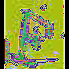

In [18]:
to_pil = T.ToPILImage()
image = to_pil(d[0][79])
image.show()